# Batch effects

This tutorial will describe a basic workflow to
1. Load in an example dataset
2. Identify batch effects in morphological profiling experiments
3. Remove those effects

Along the way, we will describe the basic anatomy of `AnnData` objects, which form
the backbone of the data structure that `scmorph` uses. For more on AnnData
objects, please refer to the package's
[documentation](https://anndata.readthedocs.io).

We will be using a minimal example dataset published in [Rohban et al.
(2017)](https://doi.org/10/ghkrp7). In it, the authors performed overexpression
experiments of genes. To start our investigation of this data, let's load it!

In [14]:
# Load scmorph
import scmorph as sm
import matplotlib.pyplot as plt

# Load in a subset of the Rohban data
# To load in the full dataset, you may use sm.datasets.rohban2017()
# but note that this will download the dataset from the internet,
# occupying ~8Gb of disk space.
adata = sm.datasets.rohban2017_minimal()

# set plotting parameters
plt.rcParams["figure.dpi"] = 200

In AnnData objects, rows represent cells and columns represent features. AnnData
compartmentalises the data into different slots. For example, the cell by
feature matrix is stored in the `.X` slot. That means that if you wish to access
it, you would use `adata.X`. Similarly, metadata about your observations (i.e.
cells) is stored in `.obs`, and metadata about variables (i.e. features) is
found in `.var`. Let's test this by seeing what metadata is attached to our cells.

In [15]:
adata.obs

,TableNumber,ImageNumber,ObjectNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,PUBLICID,TA_GeneID,Duplicate.ORFs,TARGETTRANS,Activator.Inhibitor,CONSTRUCTNAME,ISMUTANT,TARGETGENE,TA_REF.vs..DLBCL,ReferencePathway.Process
0,7a6fb88c134a0004353010f30dba103c,1,1,41744,1,a01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7a6fb88c134a0004353010f30dba103c,1,2,41744,1,a01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7a6fb88c134a0004353010f30dba103c,1,3,41744,1,a01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7a6fb88c134a0004353010f30dba103c,1,4,41744,1,a01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7a6fb88c134a0004353010f30dba103c,1,5,41744,1,a01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77417-4,dc859c7c96dd79087b6463aa30f69dd6,1116,49,41757,9,f04,BRDN0000464847,1050.0,duplicate-Cat2,NM_004364.3,0,ORF023754.1_TRC304.1,0.0,CEBPA,TA_REF,Transcription Factors
77418-4,dc859c7c96dd79087b6463aa30f69dd6,1116,50,41757,9,f04,BRDN0000464847,1050.0,duplicate-Cat2,NM_004364.3,0,ORF023754.1_TRC304.1,0.0,CEBPA,TA_REF,Transcription Factors
77419-4,dc859c7c96dd79087b6463aa30f69dd6,1116,51,41757,9,f04,BRDN0000464847,1050.0,duplicate-Cat2,NM_004364.3,0,ORF023754.1_TRC304.1,0.0,CEBPA,TA_REF,Transcription Factors
77420-4,dc859c7c96dd79087b6463aa30f69dd6,1116,52,41757,9,f04,BRDN0000464847,1050.0,duplicate-Cat2,NM_004364.3,0,ORF023754.1_TRC304.1,0.0,CEBPA,TA_REF,Transcription Factors


Information about which gene was overexpressed can be found in the `TARGETGENE`
column. For untreated cells, the published data contained missing values. Let's
fill them in with `UNTREATED` to mark negative controls.

In [16]:
adata.obs["TARGETGENE"] = adata.obs["TARGETGENE"].astype(str).replace("nan", "UNTREATED")

Note that the metadata also provides us with a hint that this data was generated
over multiple plates, which represent batches. We can see how many cells were
imaged per plate as follows:

<Axes: xlabel='Plate', ylabel='Cells'>

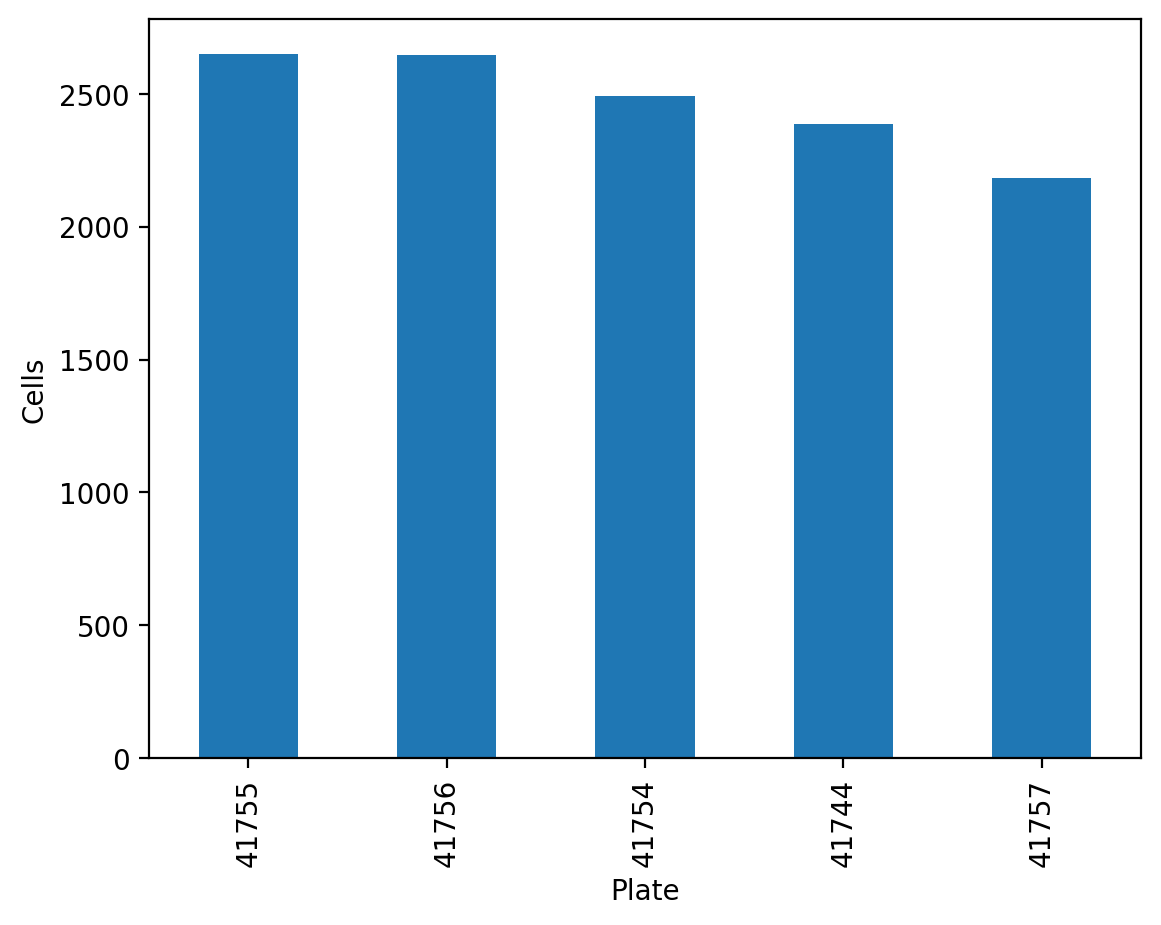

In [17]:
cells_per_plate = adata.obs["Image_Metadata_Plate"].value_counts()
cells_per_plate.plot(kind="bar", xlabel="Plate", ylabel="Cells")

Next, we will have to clean the data a bit further.

The observations that Rohban et al. 2017, provide are not all complete: some
cells did not have all features measured. Our standard workflow will start by removing
those cells.

In [18]:
# How many cells are there before filtering?
print(adata.shape)

# Remove cells with missing values
sm.pp.drop_na(adata)

# How many cells are there after filtering?
print(adata.shape)

(12352, 1687)
(12286, 1687)


Next, we may wish to remove any batch effects that may be present. We will use
the controls on each plate to normalize. Let's first look if any batch effects
are present by checking the average actin/Golgi/membrane intensity across
plates in control cells. Note that we check batch effects on control cells only to ignore any
treatment-related differences between plates.

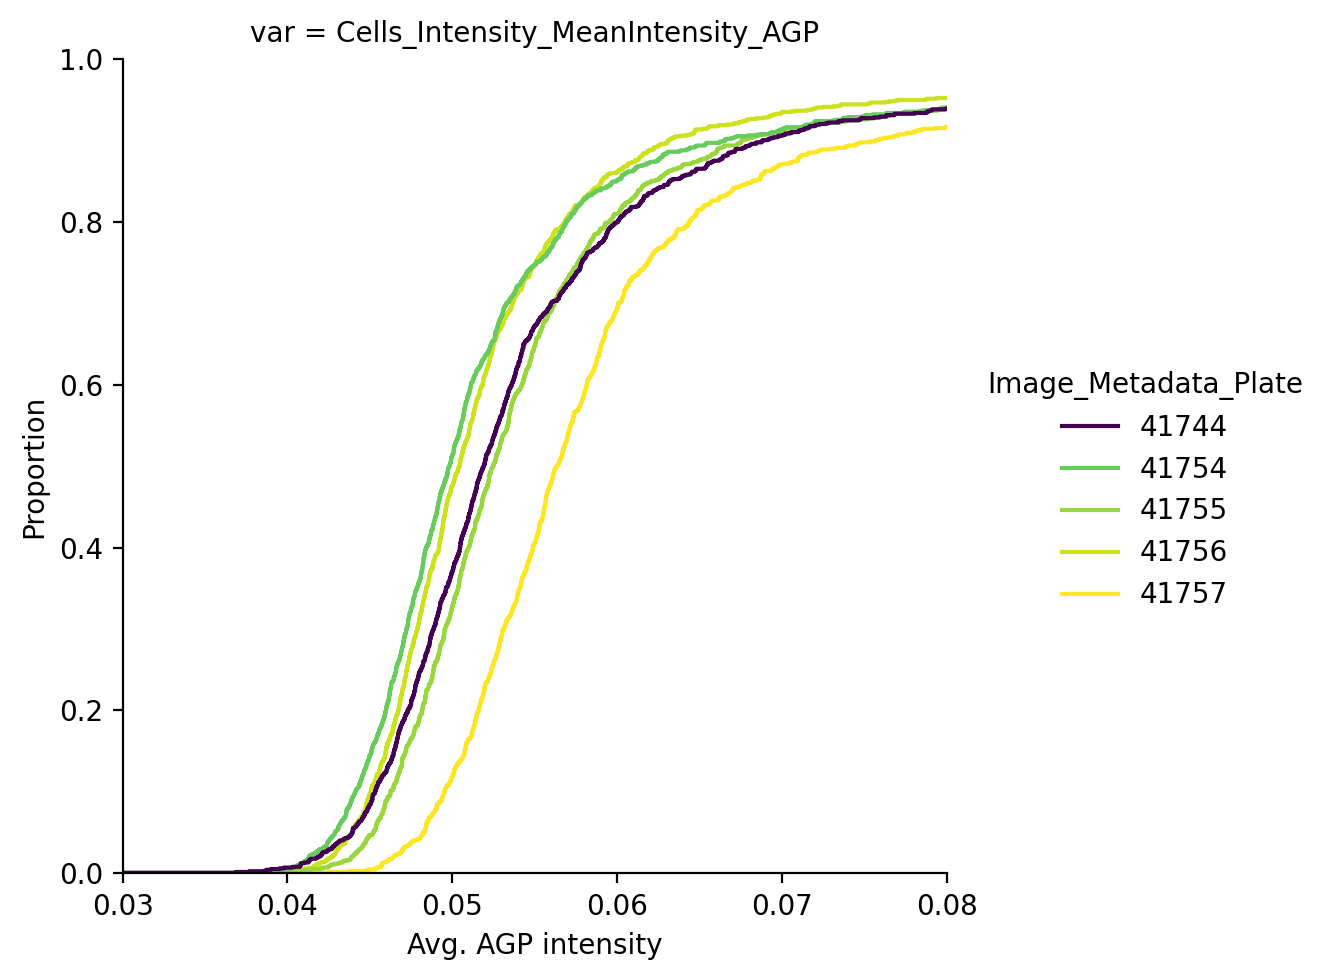

In [19]:
# Subset AnnData object to only include untreated cells
adata_ctrl = adata[adata.obs["TARGETGENE"] == "UNTREATED"]

# Use scmorph to plot the cumulative density of the mean AGP intensity
sm.pl.cumulative_density(
    adata_ctrl,
    "Cells_Intensity_MeanIntensity_AGP",
    color="Image_Metadata_Plate",
    xlim=(0.03, 0.08),
    palette="viridis",
    xlabel="Avg. AGP intensity",
)
plt.show()

You can plot any feature in `adata.var` this way. You can see all available
features using:

In [20]:
# show all features
adata.var

,Object,Module,feature_1,feature_2,feature_3,feature_4
Nuclei_AreaShape_Area,Nuclei,AreaShape,Area,NaN,NaN,NaN
Nuclei_AreaShape_Compactness,Nuclei,AreaShape,Compactness,NaN,NaN,NaN
Nuclei_AreaShape_Eccentricity,Nuclei,AreaShape,Eccentricity,NaN,NaN,NaN
Nuclei_AreaShape_EulerNumber,Nuclei,AreaShape,EulerNumber,NaN,NaN,NaN
Nuclei_AreaShape_FormFactor,Nuclei,AreaShape,FormFactor,NaN,NaN,NaN
...,...,...,...,...,...,...
Cells_Texture_Variance_Mito_3_0,Cells,Texture,Variance,Mito,3,0
Cells_Texture_Variance_Mito_5_0,Cells,Texture,Variance,Mito,5,0
Cells_Texture_Variance_RNA_10_0,Cells,Texture,Variance,RNA,10,0
Cells_Texture_Variance_RNA_3_0,Cells,Texture,Variance,RNA,3,0


In [21]:
# show all features associated with intensity measurements
adata.var.query("Module == 'Intensity'")

,Object,Module,feature_1,feature_2,feature_3,feature_4
Nuclei_Intensity_IntegratedIntensityEdge_AGP,Nuclei,Intensity,IntegratedIntensityEdge,AGP,NaN,NaN
Nuclei_Intensity_IntegratedIntensityEdge_DNA,Nuclei,Intensity,IntegratedIntensityEdge,DNA,NaN,NaN
Nuclei_Intensity_IntegratedIntensityEdge_ER,Nuclei,Intensity,IntegratedIntensityEdge,ER,NaN,NaN
Nuclei_Intensity_IntegratedIntensityEdge_Mito,Nuclei,Intensity,IntegratedIntensityEdge,Mito,NaN,NaN
Nuclei_Intensity_IntegratedIntensityEdge_RNA,Nuclei,Intensity,IntegratedIntensityEdge,RNA,NaN,NaN
...,...,...,...,...,...,...
Cells_Intensity_UpperQuartileIntensity_AGP,Cells,Intensity,UpperQuartileIntensity,AGP,NaN,NaN
Cells_Intensity_UpperQuartileIntensity_DNA,Cells,Intensity,UpperQuartileIntensity,DNA,NaN,NaN
Cells_Intensity_UpperQuartileIntensity_ER,Cells,Intensity,UpperQuartileIntensity,ER,NaN,NaN
Cells_Intensity_UpperQuartileIntensity_Mito,Cells,Intensity,UpperQuartileIntensity,Mito,NaN,NaN


Above, we saw that the average AGP intensity differs per plate. We can also see this in
PCA space, for example in PC1 the control cells look like this:

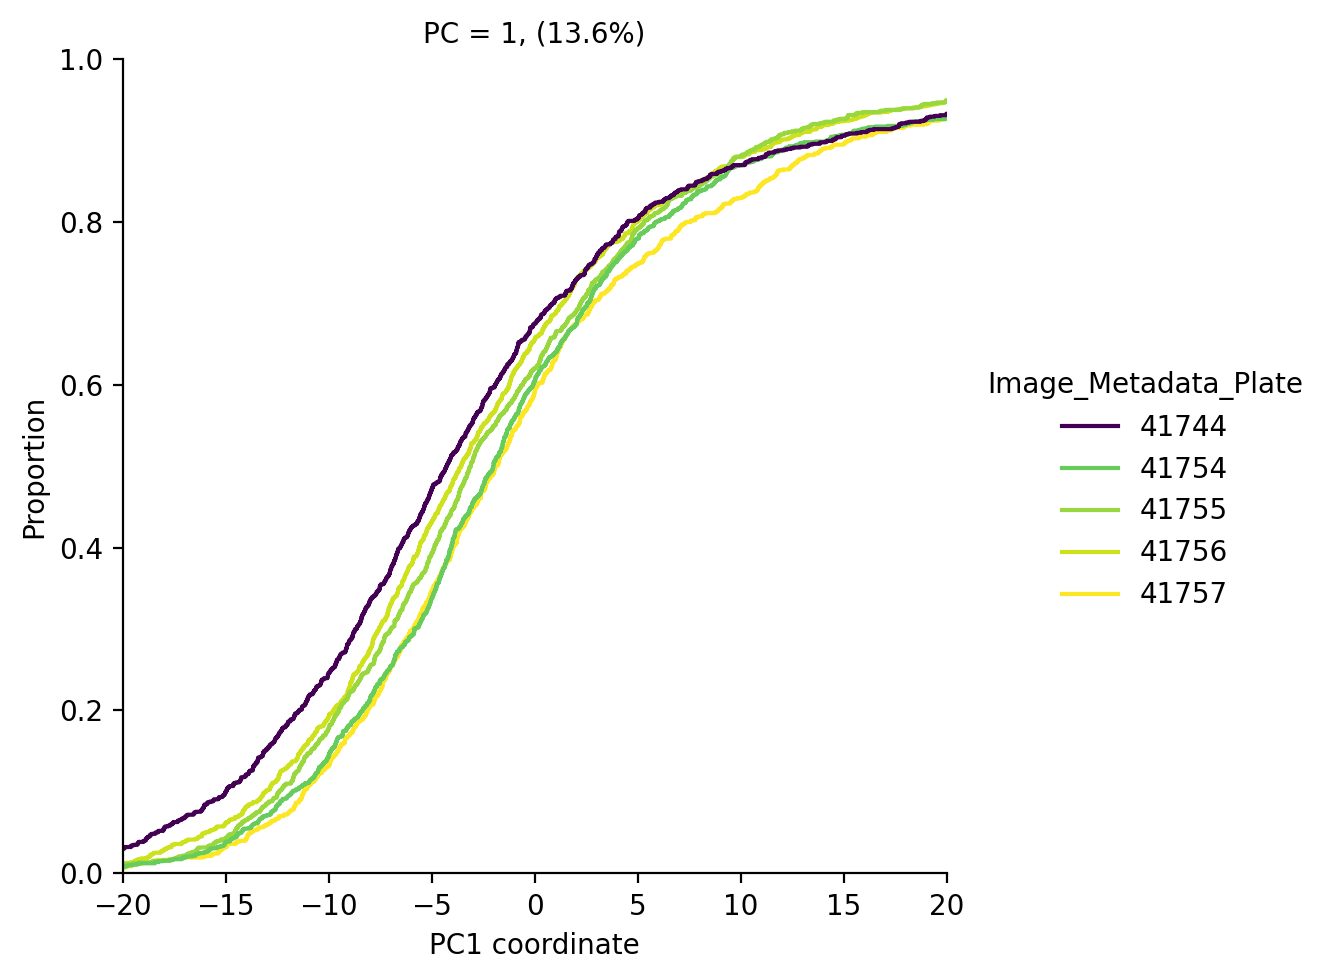

In [22]:
adata_ctrl_copy = adata_ctrl.copy()

# center-scale features
sm.pp.scale(adata_ctrl_copy)

# compute PCA
# the PCA coordinates will be stored in adata.obsm["X_pca"]
sm.pp.pca(adata_ctrl_copy)

# plot PCA coordinates
sm.pl.cumulative_density(
    adata_ctrl_copy,
    x=0,
    layer="pca",  # plot a PCA dimension, rather than a raw feature
    color="Image_Metadata_Plate",
    xlim=(-20, 20),
    palette="viridis",
    xlabel="PC1 coordinate",
)
plt.show()

Now that we have confirmed that batch effects are present in this experiment,
let's try to remove them.

In [23]:
adata_corrected = sm.pp.remove_batch_effects(
    adata,
    batch_key="Image_Metadata_Plate",
    treatment_key="TARGETGENE",
    control="UNTREATED",
    copy=True,
)

Now we can verify if the AGP feature we looked at above is still affected by
batch effects:

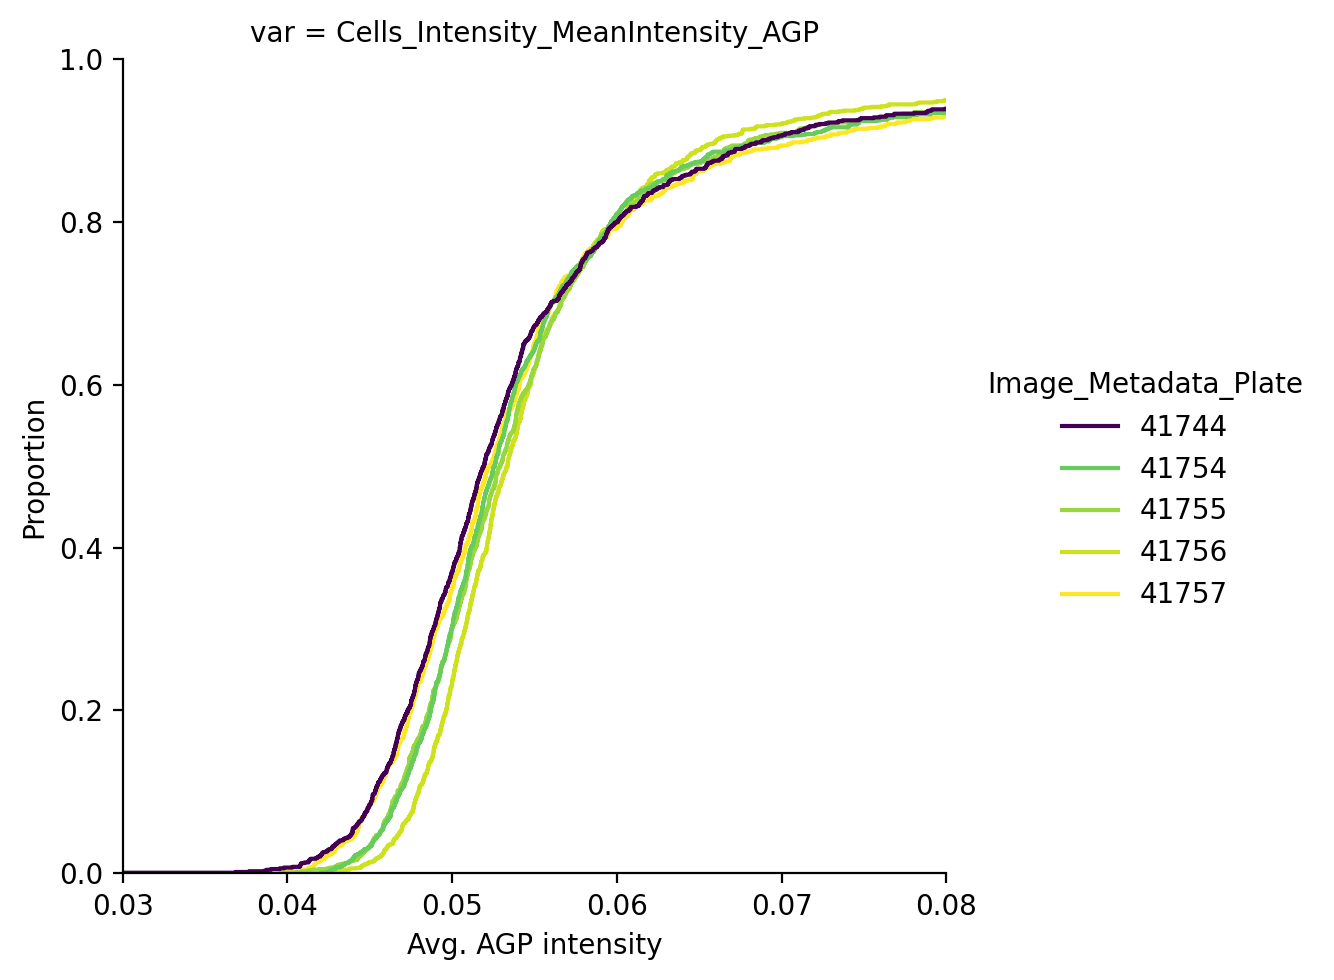

In [24]:
adata_ctrl = adata_corrected[adata_corrected.obs["TARGETGENE"] == "UNTREATED"]

sm.pl.cumulative_density(
    adata_ctrl,
    "Cells_Intensity_MeanIntensity_AGP",
    color="Image_Metadata_Plate",
    xlim=(0.03, 0.08),
    palette="viridis",
    xlabel="Avg. AGP intensity",
)
plt.show()

The batch correction technique integrated in scmorph removes the mean batch
effect per plate and will thus not lead to all of these lines perfectly
overlapping, but the result is better than doing no correction at all.
Alternatively, if downstream interpretation of features is not so important, we
may instead choose to do per-plate z-scoring.

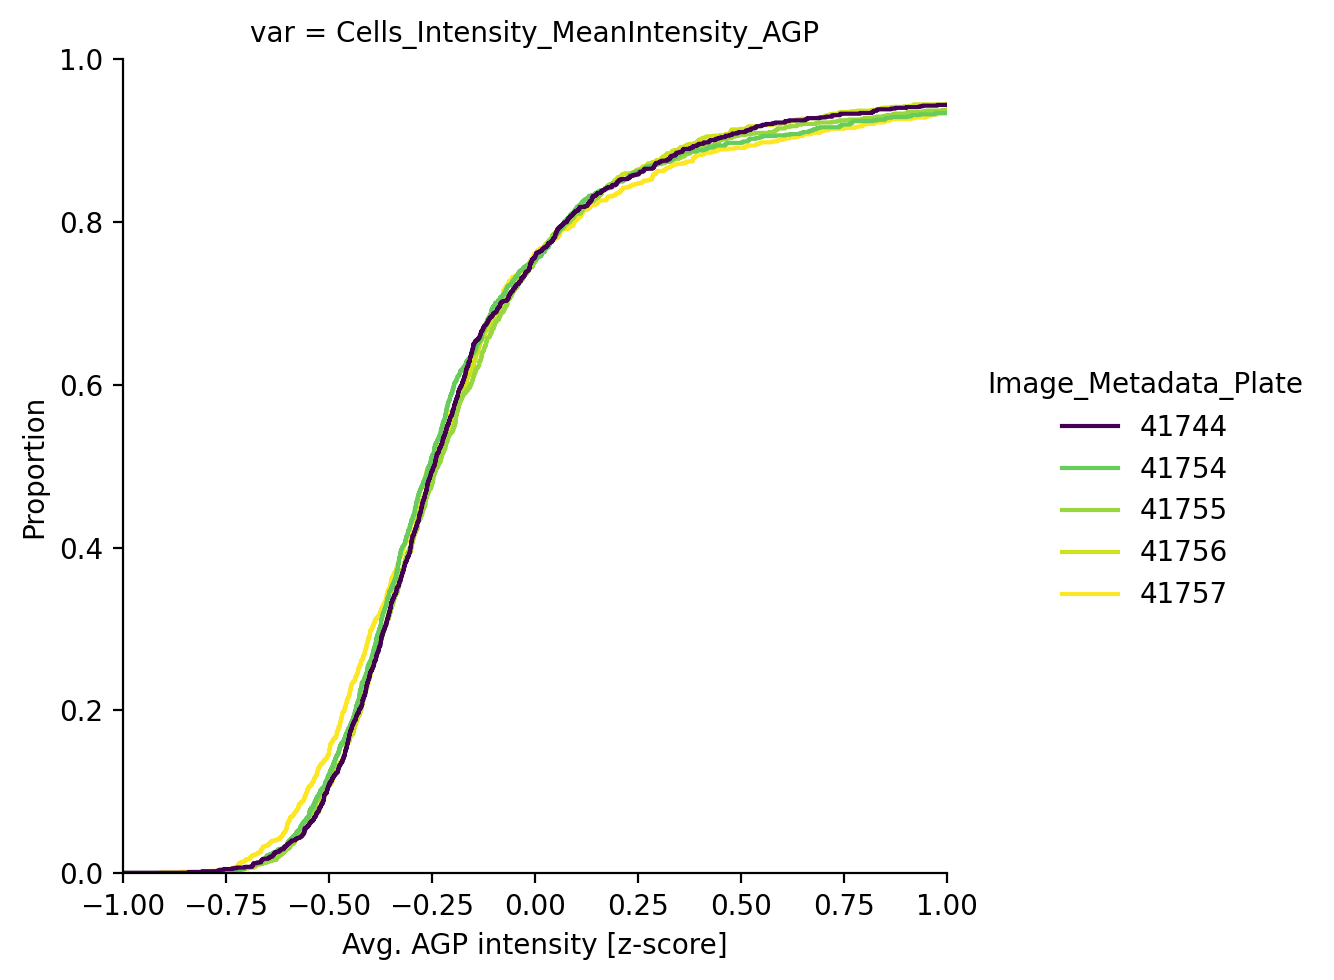

In [25]:
adata_corrected = adata.copy()

# Perform per-plate z-scoring
sm.pp.scale_by_batch(
    adata_corrected,
    batch_key="Image_Metadata_Plate",
    treatment_key="TARGETGENE",
    control="UNTREATED",
)

adata_ctrl = adata_corrected[adata_corrected.obs["TARGETGENE"] == "UNTREATED"]
sm.pl.cumulative_density(
    adata_ctrl,
    "Cells_Intensity_MeanIntensity_AGP",
    color="Image_Metadata_Plate",
    xlim=(-1, 1),
    palette="viridis",
    xlabel="Avg. AGP intensity [z-score]",
)
plt.show()

And lastly, we can also confirm that this has also removed batch effects that
were present in the PCA:

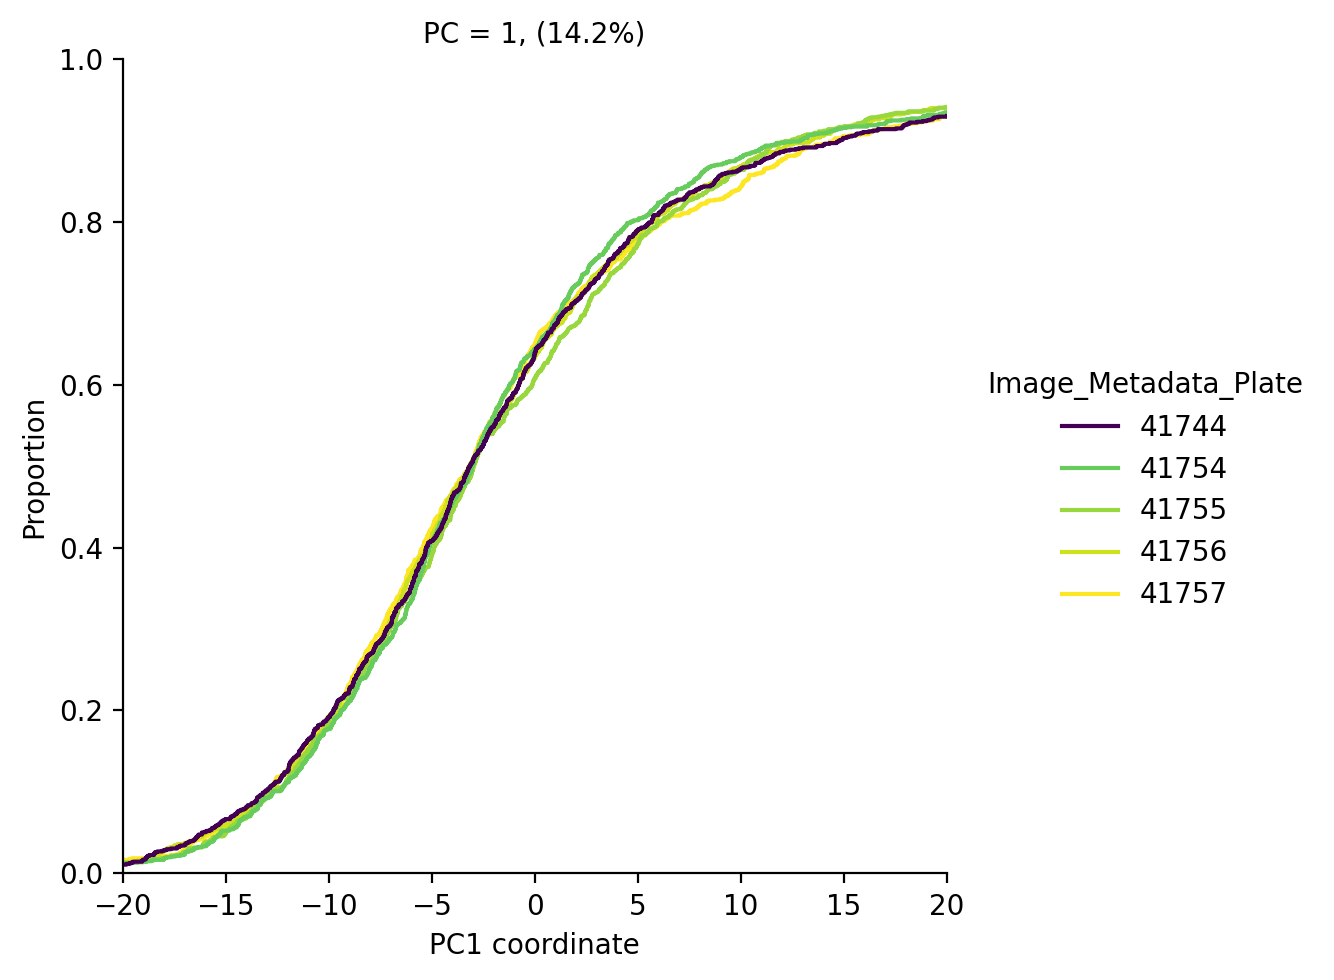

In [26]:
sm.pp.pca(adata_ctrl)

sm.pl.cumulative_density(
    adata_ctrl,
    0,
    "pca",
    color="Image_Metadata_Plate",
    xlim=(-20, 20),
    palette="viridis",
    xlabel="PC1 coordinate",
)

For more on when to choose which method to remove batch effects, also see the
companion notebook [why_scone.ipynb](why_scone.ipynb)

This concludes this tutorial, where we learnt how to
1. Load in an example dataset
2. Identify batch effects in morphological profiling experiments
3. Remove those effects